In [6]:
import pandas as pd
import numpy as np
import datetime as dt

from tqdm import tqdm_notebook as tqdm
import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# selecting all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn= conn, tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.add_constraint("start_date is not Null")
ss.load_studies()

251010 studies loaded!


In [8]:
ss.add_dimensions(['baseline_measurements', 'result_groups', 'outcome_analyses'])
ss.refresh_dim_data()
rg = ss.dimensions['result_groups']
bm = ss.dimensions['baseline_measurements']

Successfuly added these 3 dimensions: ['baseline_measurements', 'result_groups', 'outcome_analyses']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 503 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_analyses
 -- Loading raw data
 -- Sorting index


In [9]:
#Get studies with exactly two treatment groups besides "Total" and grab necessary columns
combined_measures = pd.merge(rg.data, bm.data, left_on = ['nct_id', 'id'], right_on = ['nct_id', 'result_group_id'])
combined_measures = combined_measures[combined_measures.title_x != 'Total']
num_groups = combined_measures.groupby('nct_id').ctgov_group_code_x.nunique()
num_groups = pd.DataFrame(num_groups)
num_groups.columns.values[0] = 'n_groups'
combined_measures = combined_measures.merge(num_groups, on=['nct_id'])
combined_measures = combined_measures[combined_measures.n_groups==2]
study_balance_dat = combined_measures[['ctgov_group_code_x', 'classification', 'category', 'title_y',
                                       'param_type', 'param_value_num',
                                       'dispersion_type', 'dispersion_value_num']]

In [40]:
study_balance_dat.title_y.value_counts().head(10)
#We'll go with age and sex for now

Age                           65674
Sex: Female, Male             64831
Race (NIH/OMB)                49684
Region of Enrollment          34487
Race/Ethnicity, Customized    23658
Ethnicity (NIH/OMB)           15127
Age, Customized                8575
Gender                         2318
Sex/Gender, Customized         1174
Weight                         1062
Name: title_y, dtype: int64

# Gender

In [58]:
gender_title_y = ['Sex: Female, Male', 
                  'Gender']

In [71]:
df[(df['title_y'].isin(gender_title_y)) & (df['category'] == '')]

array(['Male', 'Female'], dtype=object)

In [78]:
def get_gender(row):
    if row['category'] == '':
        return row['classification'].lower()
    else: 
        return row['category'].lower()

In [79]:
df = study_balance_dat.copy()
df['filled_gender'] = df.apply(get_gender, axis=1)
df['is_gender'] = df['title_y'].apply(lambda x: True if x in gender_title_y else False)
dfj = df[df['is_gender']].join(ss.studies[['start_date']])
dfj['start_year'] = dfj['start_date'].apply(lambda x: x.year)


In [80]:
df_gender_year = dfj.groupby(['start_year', 
                              'filled_gender'])[['param_value_num']].sum().reset_index()
df_gender_yearp = df_gender_year.pivot(index='start_year', 
                                       columns='filled_gender', 
                                       values='param_value_num')

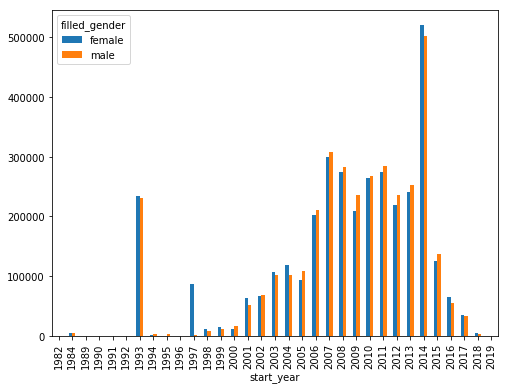

In [85]:
df_gender_yearp.plot.bar(figsize=(8, 6))
plt.show()

In [88]:
df_gres = dfj.groupby(['filled_gender'])[['param_value_num']].sum().reset_index()
df_gres['pct'] = df_gres['param_value_num'] / df_gres['param_value_num'].sum()

In [89]:
df_gres

,filled_gender,param_value_num,pct
0,female,3549945.0,0.502189
1,male,3519000.0,0.497811
